<a href="https://colab.research.google.com/github/Anay-jo/ClassifyingGalaxiesProject/blob/main/Classifying_Galaxies_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifying Galaxies Part 2**

**Authors**
Anay Joshi, Ishaan Gurazada, Ashwin Hariharan, Lukas Conover

# **Overview**

This notebook is an extension to the Classifying Galaxies notebook where we used a basic neural network to get a 70% classification accuracy for the galaxy classification problem. In this notebook, we will attempt to use more complex neural networks that can capture more patterns to see if it boosts our classification accuracy on our dataset


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip
import torch
import torch.nn as nn
import copy
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import v2

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## **Step 1: Prepare data**

Our first step in the notebook will be to get the data that we will use in our analysis.

In [ ]:
#This step is taken from the original classifying galaxies notebook
!wget https://courses.physics.illinois.edu/phys246/fa2020/code/data.pkl.zip

--2025-12-17 18:20:01--  https://courses.physics.illinois.edu/phys246/fa2020/code/data.pkl.zip
Resolving courses.physics.illinois.edu (courses.physics.illinois.edu)... 130.126.151.14
Connecting to courses.physics.illinois.edu (courses.physics.illinois.edu)|130.126.151.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299353957 (285M) [application/x-zip-compressed]
Saving to: ‘data.pkl.zip’

data.pkl.zip        100%[===================>] 285.49M  4.90MB/s    in 42s     

2025-12-17 18:20:44 (6.72 MB/s) - ‘data.pkl.zip’ saved [299353957/299353957]



In [ ]:
!unzip data.pkl.zip
(train_images_raw,train_labels,test_images_raw,test_labels) = pickle.load(open("data.pkl",'rb'))

#(train_images_raw, train_labels_raw, test_images_raw, test_labels_raw)
# = pickle.load(gzip.open("dataG.pkl.gz",'rb'))

# Convert to PyTorch Tensors & Normalize (0-255 -> 0.0-1.0)
X_train = torch.tensor(train_images_raw).float() / 255.0
X_test  = torch.tensor(test_images_raw).float() / 255.0

# Move channels to PyTorch format (N, C, H, W)
X_train = torch.moveaxis(X_train, 3, 1)
X_test  = torch.moveaxis(X_test, 3, 1)

# Convert Labels from One-Hot to Indices
y_train = torch.tensor(train_labels)
y_test  = torch.tensor(test_labels)

y_train = torch.argmax(y_train, dim=1)
y_test  = torch.argmax(y_test, dim=1)

# shuffle data
perm = torch.randperm(len(X_train))
X_train = X_train[perm]
y_train = y_train[perm]

# Create Validation Split (80% Train, 20% Validation)
split_idx = int(0.8 * len(X_train))

X_val = X_train[split_idx:]
y_val = y_train[split_idx:]

X_train = X_train[:split_idx]
y_train = y_train[:split_idx]

# Create DataLoaders
BATCH_SIZE = 64

train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)
test_ds  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data Loaded: {len(X_train)} Train, {len(X_val)} Val\
, {len(X_test)} Test")

Archive:  data.pkl.zip
  inflating: data.pkl                
   creating: __MACOSX/
  inflating: __MACOSX/._data.pkl     
Data Loaded: 15684 Train, 3922 Val, 2179 Test


## **Model Architecture**


In [ ]:
class GalaxyCNN(nn.Module):
    def __init__(self):
        super(GalaxyCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## **Training**

In [ ]:
# Training setup
model = GalaxyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), \
                            lr=3e-4, weight_decay=1e-4) # Lower LR for stability

# Augmentation
aug_transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(15),
])

In [ ]:
# Training loop
epochs = 1000
train_losses = []
val_accuracies = []

# Variables to track best model
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

patience = 15 # How many epochs to wait before stopping
patience_counter = 0

for epoch in range(epochs):
    # Train
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images = aug_transform(images)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_accuracies.append(val_acc)

    # Check if this is the best model so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_train_loss:.4f}\
     | Val Acc: {val_acc:.2%} (Best: {best_val_acc:.2%})")

    # Early Stopping Break Condition
    if patience_counter >= patience:
        print(f"\nEarly Stopping triggered! No improvement \
        for {patience} epochs.")
        break

model.load_state_dict(best_model_wts)

Epoch 1/1000 | Loss: 1.4195     | Val Acc: 51.48% (Best: 51.48%)
Epoch 2/1000 | Loss: 1.1808     | Val Acc: 56.25% (Best: 56.25%)
Epoch 3/1000 | Loss: 1.0868     | Val Acc: 65.15% (Best: 65.15%)
Epoch 4/1000 | Loss: 1.0177     | Val Acc: 62.57% (Best: 65.15%)
Epoch 5/1000 | Loss: 0.9622     | Val Acc: 70.83% (Best: 70.83%)
Epoch 6/1000 | Loss: 0.9103     | Val Acc: 72.90% (Best: 72.90%)
Epoch 7/1000 | Loss: 0.8724     | Val Acc: 69.53% (Best: 72.90%)
Epoch 8/1000 | Loss: 0.8361     | Val Acc: 71.80% (Best: 72.90%)
Epoch 9/1000 | Loss: 0.7973     | Val Acc: 71.37% (Best: 72.90%)
Epoch 10/1000 | Loss: 0.7835     | Val Acc: 75.50% (Best: 75.50%)
Epoch 11/1000 | Loss: 0.7736     | Val Acc: 72.90% (Best: 75.50%)
Epoch 12/1000 | Loss: 0.7456     | Val Acc: 77.43% (Best: 77.43%)
Epoch 13/1000 | Loss: 0.7351     | Val Acc: 76.31% (Best: 77.43%)
Epoch 14/1000 | Loss: 0.7285     | Val Acc: 76.36% (Best: 77.43%)
Epoch 15/1000 | Loss: 0.7145     | Val Acc: 77.66% (Best: 77.66%)
Epoch 16/1000 | Los

<All keys matched successfully>

## **Plotting and testing**

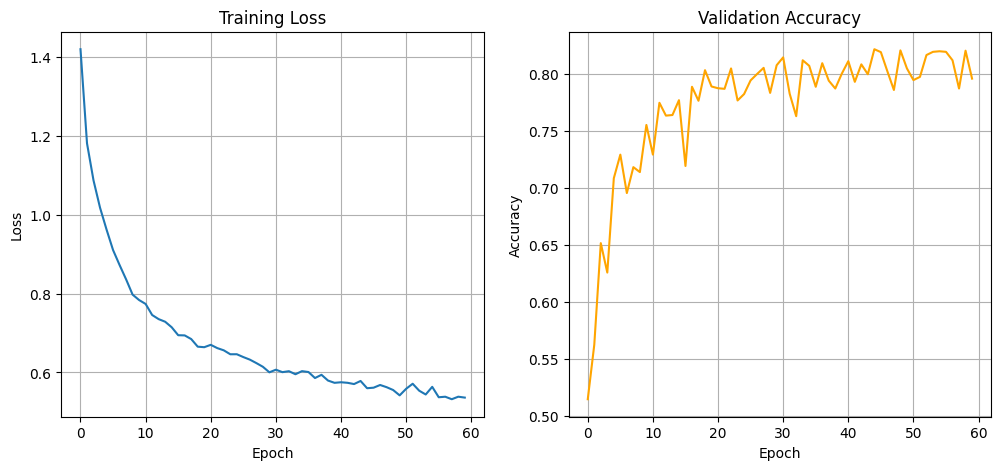

Final Test Set Accuracy: 82.06%


In [ ]:
# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# 7. Final test
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Set Accuracy: {correct/total:.2%}")

##**Citations**


https://www.geeksforgeeks.org/deep-learning/train-a-deep-learning-model-with-pytorch/
https://www.digitalocean.com/community/tutorials/vgg-from-scratch-pytorch
https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
https://pytorch.org/vision/stable/transforms.html
https://medium.com/@vrunda.bhattbhatt/a-step-by-step-guide-to-early-stopping-in-tensorflow-and-pytorch-59c1e3d0e376

